# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [38]:
import twitter

CONSUMER_KEY = "wTOj2975uKAhyIyJkrjod2wju"
CONSUMER_SECRET = "v0IpKZ6LxnUN0DgGGAmLE7tgzjiK6u5zMYZnSIFX5ghN8hUoTp"

ACCESS_TOKEN_KEY = "272608335-xS7I2zHOzMQHaI2eSO3RTsPVi8XwOOajXsMxLW1P"
ACCESS_TOKEN_SECRET = "04aF4bmEktxhNv6jpi5QOESYIdLALUAiSmLJgs4h66q6H"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

In [39]:
import pymongo

DATABASE_URL = 'mongodb://myserver:27017/'


client = pymongo.MongoClient(DATABASE_URL)
shpere_db = client.shpere


Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [40]:
import json
def load_twitts(path):
    print "Reading users twitts from %s ..." % path
    with open(path, 'r') as infile:
        twitts = json.load(infile)
        return twitts

twts = load_twitts('files/twitts.json')

Reading users twitts from files/twitts.json ...


In [41]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    user_twts = twts.get("%s" % user_id)
    if not user_twts:
        return []
    data = {
        'lang': 1,
        'favorited': 1,
        'truncated': 1,
        'text': 1,
        'created_at': 1,
        'retweeted': 1,
        'source': 1,
        'user': 1,
        'id': 1,
    }

    user_twts = [{key: value for key, value in twt.items() if key in data}
                                               for twt in user_twts if twt]
    return user_twts

# def get_user_tweets(user_id):
#     """returns list of tweets as dicts"""
#     fields = {
#         'lang': 1,
#         'favorited': 1,
#         'truncated': 1,
#         'text': 1,
#         'created_at': 1,
#         'retweeted': 1,
#         'source': 1,
#         'user': 1,
#         'id': 1,
#         '_id': 0
#     }
#     return list(shpere_db.twitts.find({u"user_id": u"%s" % user_id}, fields))

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [44]:
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def get_words(text):
    """returns list of words"""
    return [word.lower() for word in tokenizer.tokenize(text)]

In [45]:
print get_words("Here are different words!")

['here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [46]:
import nltk
# nltk.download()
# nltk.download("stopwords")

xДля дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [60]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

wnl = WordNetLemmatizer()

def get_tokens(words):
    """returns list of tokens"""
    words = [wnl.lemmatize(token) for token in words]
    
    missed_stopwords = [u"m", u"u", u"wa", u"ha", u"http", u"co", u"t", u"rt"]
    filtered_words = [word for word in words if word not in missed_stopwords + stopwords.words('english')]

    return filtered_words

In [61]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [62]:
def get_tweet_tokens(tweet):
    words = get_words(tweet)
    return get_tokens(words)

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [63]:
import sys
from collections import Counter

def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    tokens_counters = []
    length = len(df_users.index)

    for i, twitter_id in enumerate(df_users.twitter_id.tolist()):
        sys.stdout.write('\r' + "%s/%s Precessing user_id=%s." % (i, length, twitter_id))
        sys.stdout.flush()

        tweets_texts = [tweet.get("text") for tweet in get_user_tweets(twitter_id)]
        merged_text = ' '.join(tweets_texts)
        
        tokens = get_tweet_tokens(merged_text)
        tokens_counters.append(Counter(tokens))
        
    return df_users.twitter_id.tolist(), tokens_counters

In [64]:
import json
import pandas as pd

from collections import defaultdict
from sklearn.feature_extraction import DictVectorizer

TRAINING_SET_URL = "../hw1/twitter_train.csv"


df_users = pd.read_csv(TRAINING_SET_URL, sep=",")
users, users_tokens = collect_users_tokens(df_users)

v = DictVectorizer()
vs = v.fit_transform(users_tokens)

2999/3000 Precessing user_id=237188227.

In [7]:
import numpy as np
np.savez("files/out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [33]:
import numpy as np

words_counter = np.load('files/counted_tags.dat.npz')
words_counter = words_counter["data"].tolist()

missed_stopwords = ["m", "u", "wa", "ha"]

for stopword in missed_stopwords:
        del words_counter[stopword]

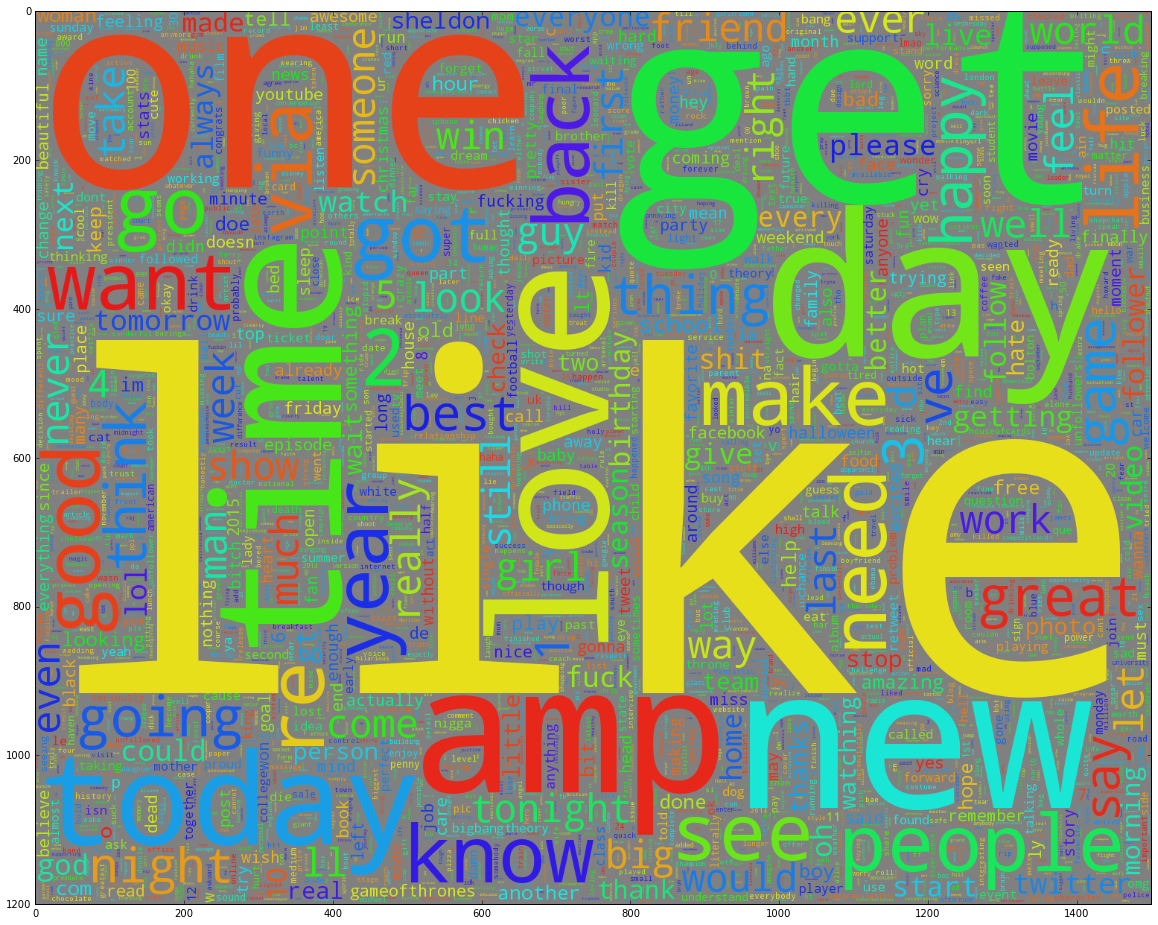

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

def draw_tag_cloud(words_frequencies):
    missed_stopwords = ["m", "u", "wa", "ha"]

    for stopword in missed_stopwords:
            del counted_tags[stopword]


    wordcloud_params = {
        "font_path": None,
        "width": 1500,
        "height": 1200,
        "margin": 2,
        "ranks_only": False,
        "prefer_horizontal": 0.5,
        "mask": None,
        "scale": 1,
        "max_words": 200,
        "min_font_size": 4,
        "stopwords": [u'm'],
        "random_state": None,
        "background_color": 'gray',
        "max_font_size": None,
        "font_step": 1
    }
    wc = WordCloud(**wordcloud_params).fit_words(counted_tags.most_common())
    
    wc.to_file("files/words_cloud.png")
    
    plt.figure(figsize=(20, 20))
    plt.imshow(wc)


draw_tag_cloud(words_counter.most_common())